## 1. Data Collection and Preparation

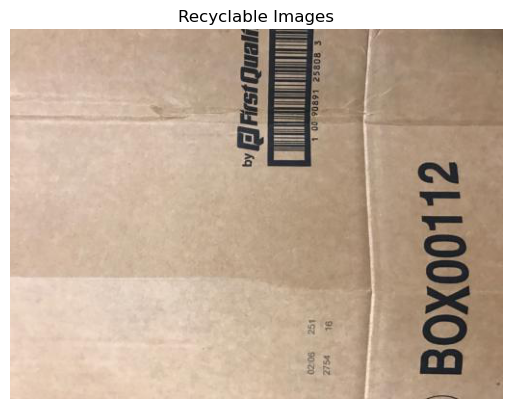

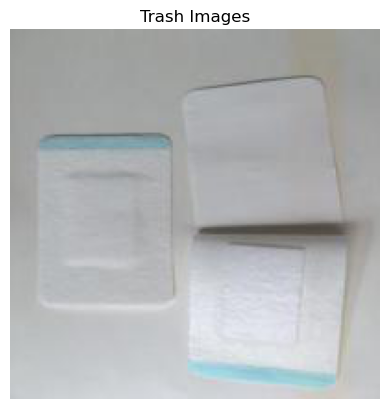

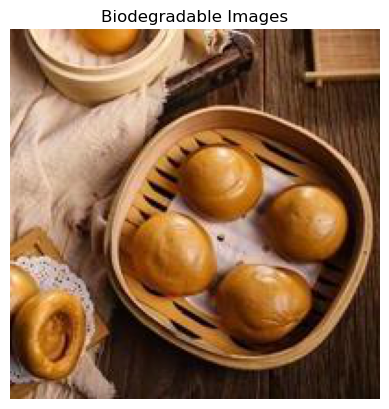

Found 312 images belonging to 3 classes.
Found 78 images belonging to 3 classes.
Class Indices: {'Biodegradable Images': 0, 'Recyclable Images': 1, 'Trash Images': 2}


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset path
dataset_path = "dataset"  # Change this if your folder is named differently

# Preview sample images from each class
classes = ['Recyclable Images', 'Trash Images', 'Biodegradable Images']
for cls in classes:
    img_folder = os.path.join(dataset_path, cls)
    img_file = os.listdir(img_folder)[0]
    img_path = os.path.join(img_folder, img_file)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
    plt.show()

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Show class indices
print("Class Indices:", train_gen.class_indices)


## 2. Model Building with Transfer Learning

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 3. Model Training and Evaluation

c:\Users\vedab\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 846ms/step - accuracy: 0.5440 - loss: 1.0166 - val_accuracy: 0.6282 - val_loss: 0.7925
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 592ms/step - accuracy: 0.9231 - loss: 0.2719 - val_accuracy: 0.5897 - val_loss: 0.9643
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 650ms/step - accuracy: 0.9080 - loss: 0.1803 - val_accuracy: 0.5385 - val_loss: 1.1762
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 632ms/step - accuracy: 0.9642 - loss: 0.1280 - val_accuracy: 0.5769 - val_loss: 1.2563
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 679ms/step - accuracy: 0.9880 - loss: 0.0685 - val_accuracy: 0.5769 - val_loss: 1.2596
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 797ms/step - accuracy: 0.9684 - loss: 0.0705 - val_accuracy: 0.5769 - val_loss: 1.1758
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 758ms/step - accuracy: 0.9901 - loss: 0.0535 - val_accuracy: 0.5769 - val_loss: 1.3506
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 722ms/step - accuracy: 0.9914 - loss: 0.0428 - val_accuracy: 0

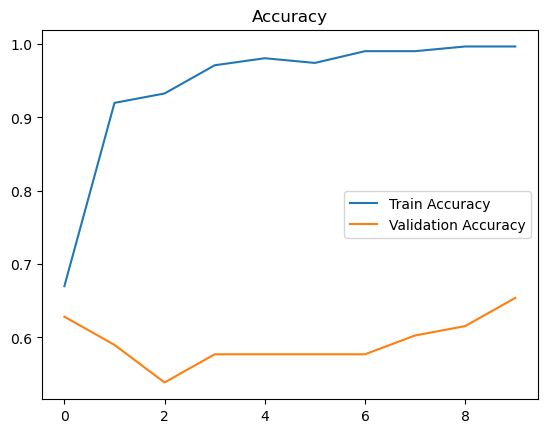

In [3]:
# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Save the model
model.save("waste_classifier_model.h5")


In [4]:
import cv2
print("OpenCV version:", cv2.__version__)


OpenCV version: 4.11.0


In [5]:
%pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


## 4. Model Testing on New Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


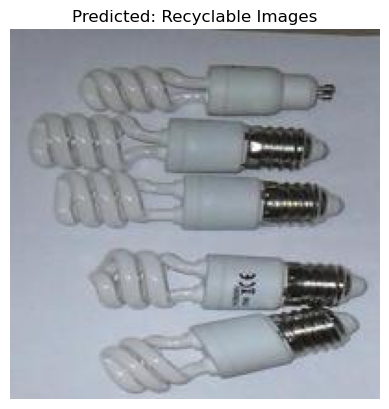

In [12]:
from tensorflow.keras.models import load_model
import cv2

model = load_model("waste_classifier_model.h5")
labels = list(train_gen.class_indices.keys())

# Load and predict new image
img_path = r"C:\Users\vedab\OneDrive\Desktop\CleanTech\Dataset\Trash Images\TRAIN.4_NBIODEG_CCW_1237.jpg"  # replace with your image path
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (224, 224)) / 255.0
img_array = np.expand_dims(img_resized, axis=0)

pred = model.predict(img_array)
predicted_label = labels[np.argmax(pred)]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()
